- 동시 VACUUM은 작동에 필수적이지만 충분하지는 않음.
  - 예를 들어 데드 튜플을 많이 제거하더라도 테이블 크기를 줄일 수 없음.

- 그림은 극단적인 예를 보여줌.
  - 테이블이 3개의 페이지로 구성되어 있고 각 페이지에 6개의 튜플이 포함되어 있다고 가정.
  - 다음 DELETE 명령은 튜플을 제거하기 위해 실행되고, VACUUM 명령은 데드 튜플을 제거하기 위해 실행됨.



**An example showing the disadvantages of (concurrent) VACUUM.**

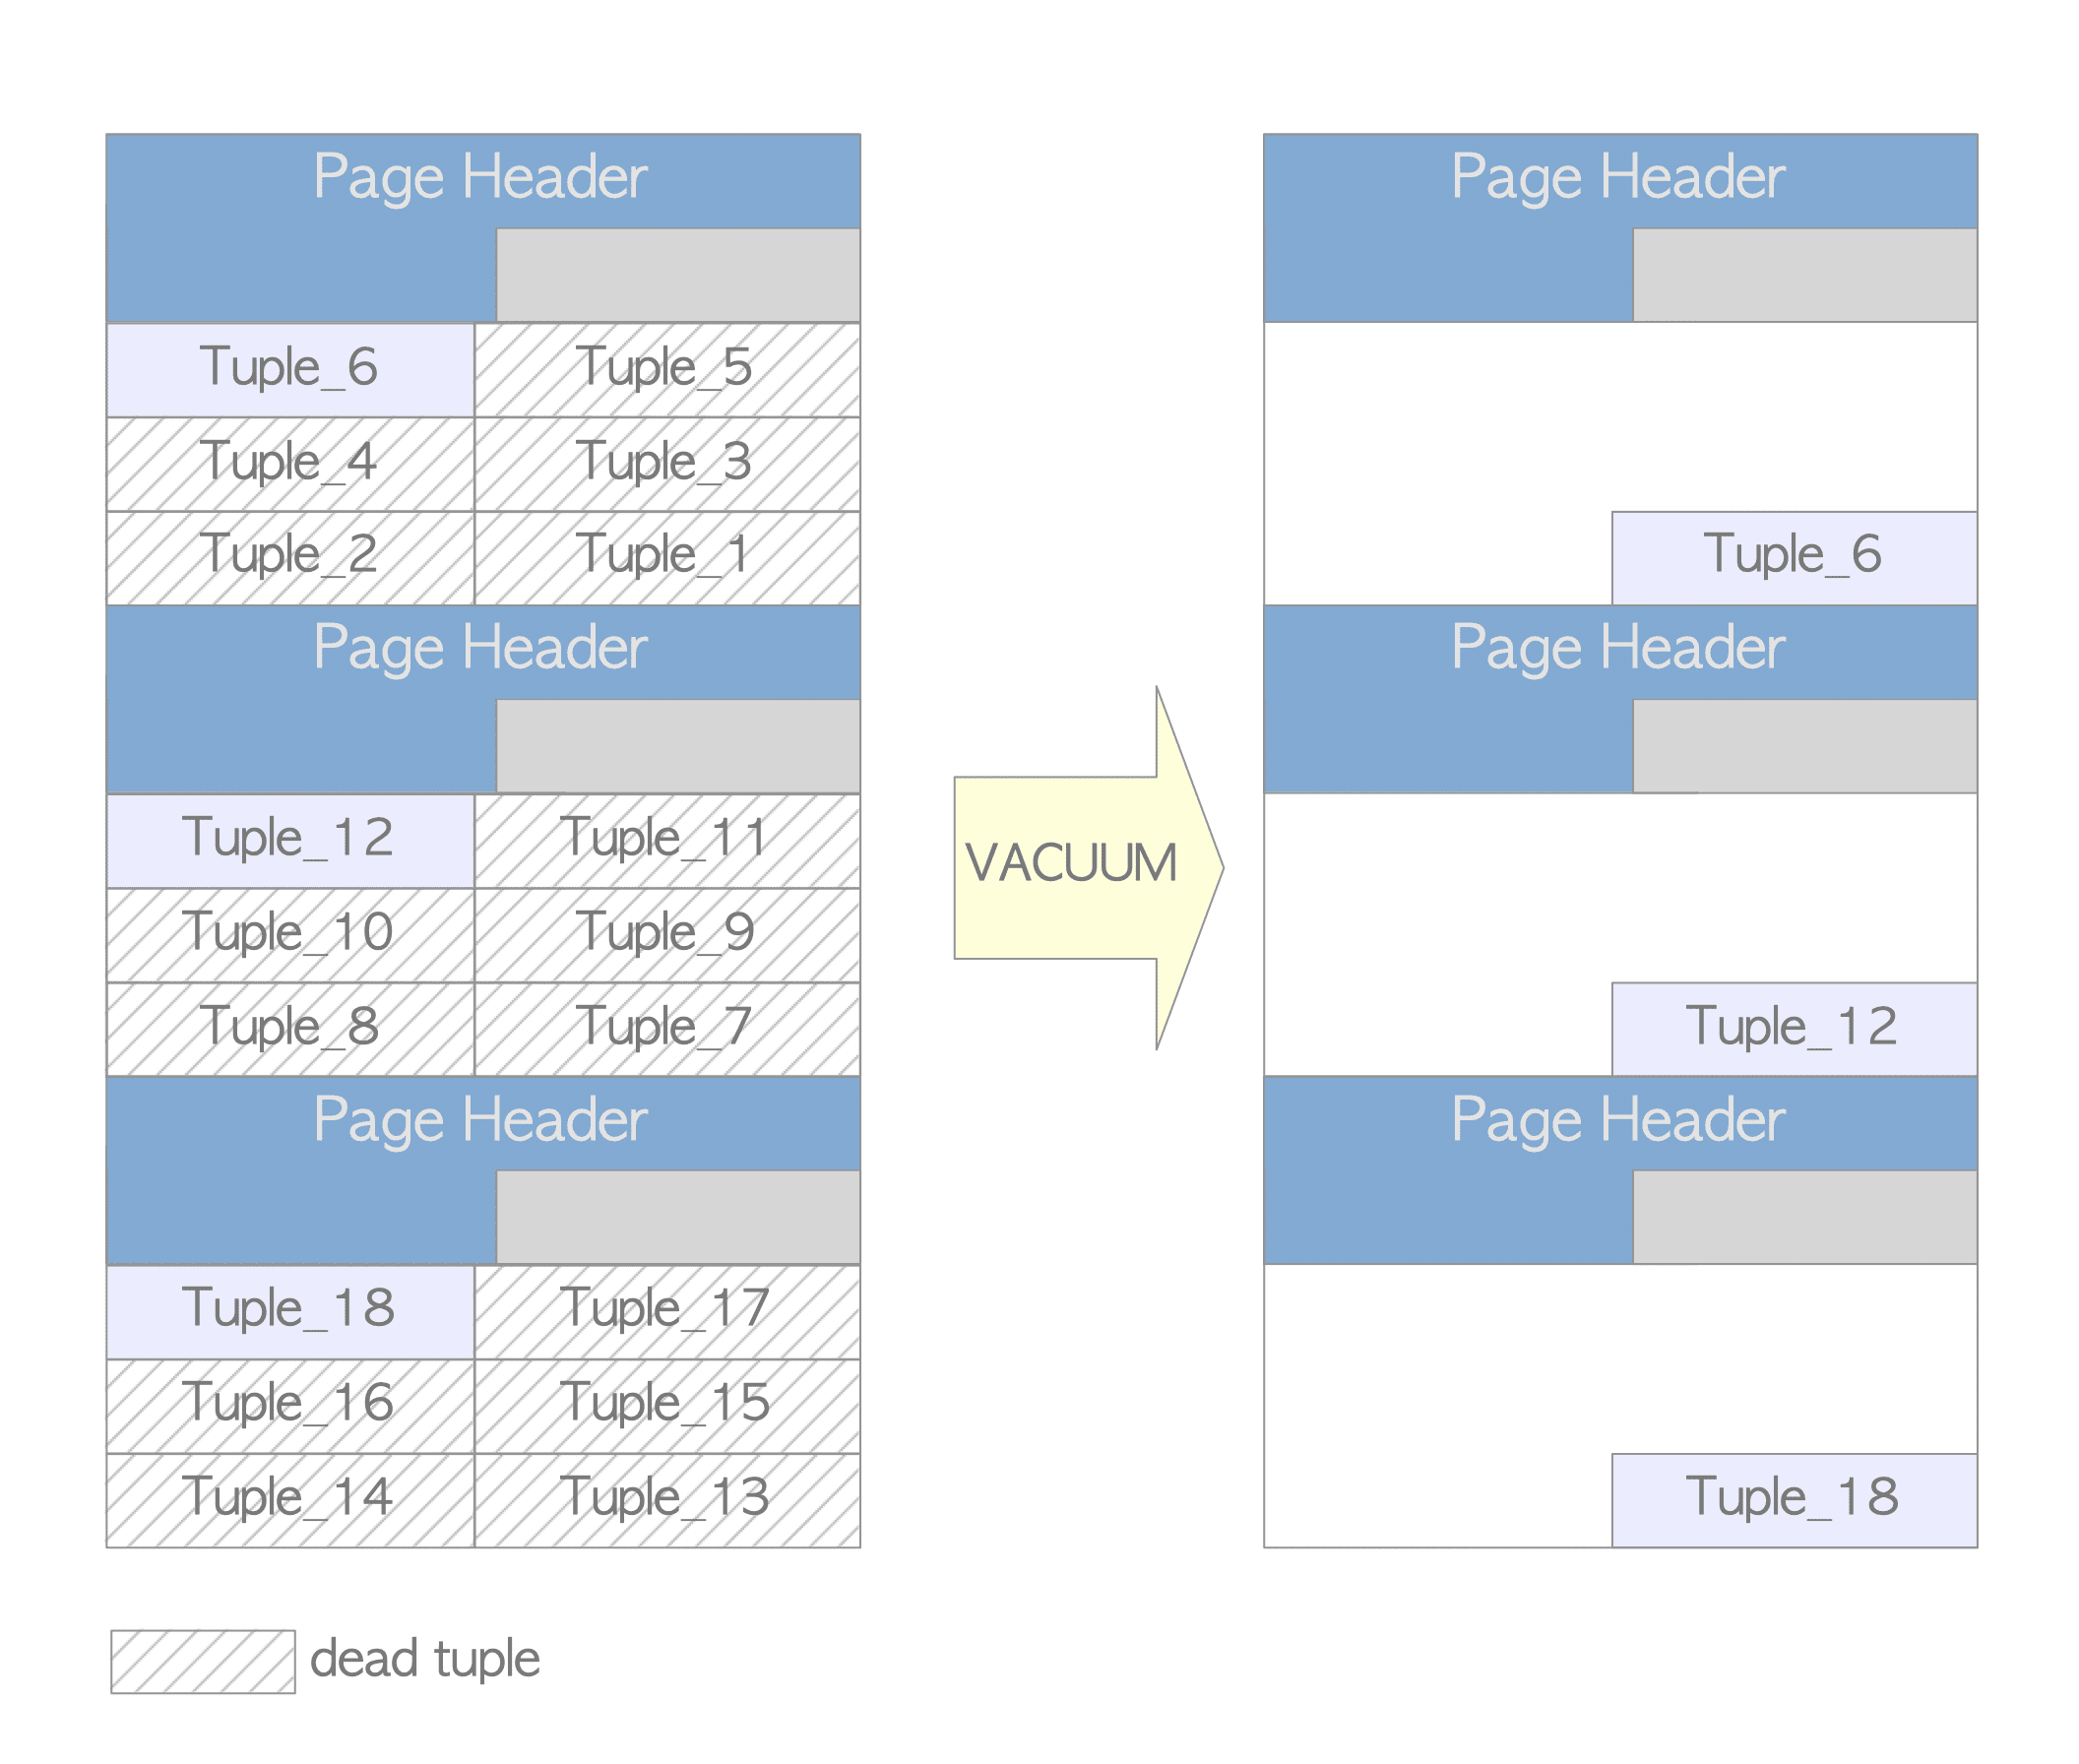




```
testdb=# DELETE FROM tbl WHERE id % 6 != 0;
testdb=# VACUUM tbl;
```

- 데드 튜플은 제거됨.
  - 그러나 테이블 크기는 줄어들지 않음.
  - 이는 디스크 공간 낭비이며 데이터베이스 성능에 부정적인 영향을 미침.
  - 예를 들어 위의 예에서 테이블의 3개 튜플을 읽으려면 디스크에서 3개의 페이지를 로드해야 함.

- 이러한 상황을 처리하기 위해 PostgreSQL은 Full VACUUM 모드를 제공

**Outline of Full VACUUM mode.**

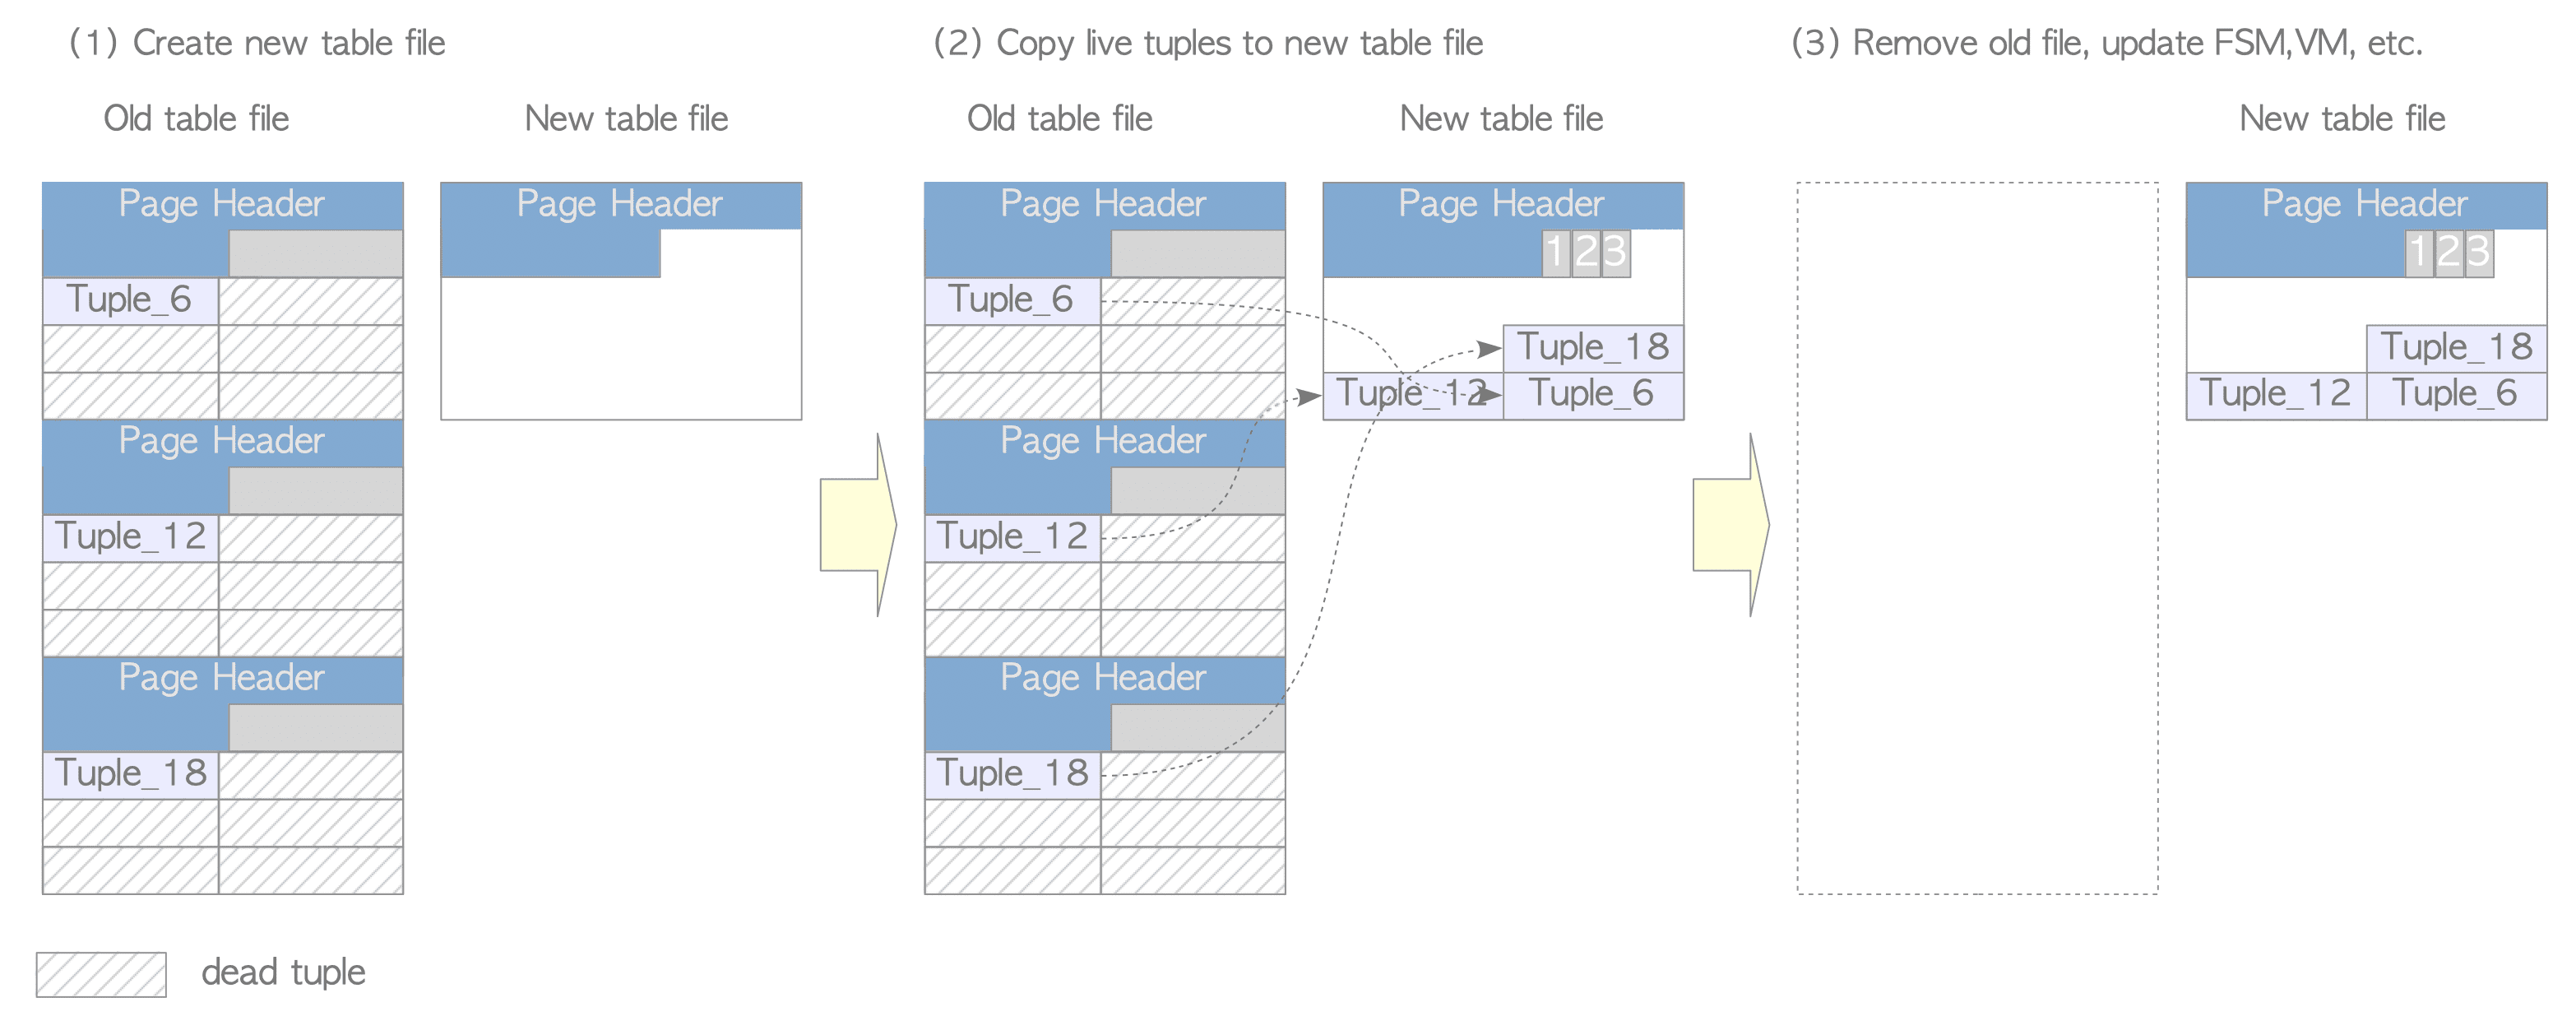

1. 새 테이블 파일 생성

- 테이블에 대해 VACUUM FULL 명령이 실행되면 PostgreSQL은 먼저 해당 테이블에 대해 AccessExclusiveLock 잠금을 획득하고 크기가 8KB인 새 테이블 파일을 생성.
- AccessExclusiveLock 잠금은 다른 사용자가 테이블에 액세스하는 것을 방지.

2. 라이브 튜플을 새 테이블에 복사

- PostgreSQL은 이전 테이블 파일 내의 라이브 튜플만 새 테이블에 복사.

3. 이전 파일 제거, 인덱스 재구축, 통계, FSM 및 VM 업데이트

- 모든 라이브 튜플을 복사한 후 PostgreSQL은 이전 파일을 제거하고 관련된 모든 테이블 인덱스를 재구축하고 FSM과 VM을 모두 업데이트.
- 이 테이블의 VM, 관련 통계 및 시스템 카탈로그를 업데이트.

**Pseudocode: Full VACUUM**



```
(1)  FOR each table
(2)     Acquire AccessExclusiveLock lock for the table
(3)     Create a new table file
(4)     FOR each live tuple in the old table
(5)        Copy the live tuple to the new table file
(6)        Freeze the tuple IF necessary
        END FOR
(7)     Remove the old table file
(8)     Rebuild all indexes
(9)     Update FSM and VM
(10)    Update statistics
        Release AccessExclusiveLock lock
     END FOR
(11) Remove unnecessary clog files and pages if possible
```

- VACUUM FULL 명령을 사용할 때는 두 가지 사항을 고려해야 함.
  - Full VACUUM 처리 중에는 누구도 테이블에 접근(읽기/쓰기)할 수 없음.
  - 테이블 디스크 공간의 최대 2배가 일시적으로 사용됨.
    - 따라서 대용량 테이블을 처리할 때에는 디스크의 남은 용량을 확인하는 것이 필요.

**When should I do VACUUM FULL?**

- 언제 VACUUM FULL을 실행해야 하는지에 대한 질문에 대한 일률적인 답변은 없음.
- 그러나 pg_freespacemap 확장은 몇 가지 좋은 제안을 제공할 수 있음.

- 다음 쿼리는 알고 싶은 테이블의 평균 여유 공간 비율을 보여줌.

```
testdb=# CREATE EXTENSION pg_freespacemap;
CREATE EXTENSION

testdb=# SELECT count(*) as "number of pages",
       pg_size_pretty(cast(avg(avail) as bigint)) as "Av. freespace size",
       round(100 * avg(avail)/8192 ,2) as "Av. freespace ratio"
       FROM pg_freespace('accounts');
 number of pages | Av. freespace size | Av. freespace ratio
-----------------+--------------------+---------------------
            1640 | 99 bytes           |                1.21
(1 row)
```

- 위의 결과와 같이 여유 공간이 거의 없음을 알 수 있음(1.21% 여유 공간).

- 거의 튜플을 삭제하고 VACUUM 명령을 실행하면 거의 페이지가 비어 있지만(86.97% 여유 공간) 페이지 수는 동일하게 유지되는 것을 확인할 수 있음.
- 즉, 테이블 파일이 압축되지 않음.

```
testdb=# DELETE FROM accounts WHERE aid %10 != 0 OR aid < 100;
DELETE 90009

testdb=# VACUUM accounts;
VACUUM

testdb=# SELECT count(*) as "number of pages",
       pg_size_pretty(cast(avg(avail) as bigint)) as "Av. freespace size",
       round(100 * avg(avail)/8192 ,2) as "Av. freespace ratio"
       FROM pg_freespace('accounts');
 number of pages | Av. freespace size | Av. freespace ratio
-----------------+--------------------+---------------------
            1640 | 7124 bytes         |               86.97
(1 row)
```

- 다음 쿼리는 지정된 테이블의 각 페이지에 대한 여유 공간 비율을 검사.

```
testdb=# SELECT *, round(100 * avail/8192 ,2) as "freespace ratio"
                FROM pg_freespace('accounts');
 blkno | avail | freespace ratio
-------+-------+-----------------
     0 |  7904 |           96.00
     1 |  7520 |           91.00
     2 |  7136 |           87.00
     3 |  7136 |           87.00
     4 |  7136 |           87.00
     5 |  7136 |           87.00
....
```

- 이런 상황에서 VACUUM FULL을 실행하면 테이블 파일이 압축된 것을 확인할 수 있음.

```
testdb=# VACUUM FULL accounts;
VACUUM
testdb=# SELECT count(*) as "number of blocks",
       pg_size_pretty(cast(avg(avail) as bigint)) as "Av. freespace size",
       round(100 * avg(avail)/8192 ,2) as "Av. freespace ratio"
       FROM pg_freespace('accounts');
 number of pages | Av. freespace size | Av. freespace ratio
-----------------+--------------------+---------------------
             164 | 0 bytes            |                0.00
(1 row)
```